## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os

from unet import unet
from utils.dataset_utils import load_dataset_split, save_images, load_results
from utils.dataset_utils import load_images_from_list
from utils.preprocessing import merge_patches_directly_and_save_all
from utils.preprocessing import merge_patches_from_dir_and_save_all
from utils.vis_utils import plot_image_mask_prediction

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### 1.1 Parameters of the experiment (and hyperparameters from ../config.py)

In [4]:
UNET_NAME = config.UNET_NAME
EXPERIMENT_NAME = config.EXPERIMENT_NAME
DATASET_PATH = f'../datasets/{config.DATASET_NAME}'
UNSEEN_CATEGORIES_PATH = f'../datasets/unseen_categories'

In [5]:
CHECKPOINTS_PATH = f'../checkpoints'
CHECKPOINT_FILENAME = f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}/{UNET_NAME}.hdf5'
LOGS_PATH = f'../logs'
LOGS_FILENAME = f'{LOGS_PATH}/{EXPERIMENT_NAME}.json'
RESULTS_PATH = f'../results/{EXPERIMENT_NAME}'

## 2. Load the dataset splits

In [6]:
train_images, train_masks, train_img_names = load_dataset_split(DATASET_PATH, 'train')
val_images, val_masks, val_img_names = load_dataset_split(DATASET_PATH, 'val')
test_images, test_masks, test_img_names = load_dataset_split(DATASET_PATH, 'test')

train_masks = train_masks[..., np.newaxis]
val_masks = val_masks[..., np.newaxis]
test_masks = test_masks[..., np.newaxis]

if config.INPUT_SHAPE[2] > 3:
    sal_maps = {}
    for split_name, img_names in zip(['train', 'val', 'test'], 
                                     [train_img_names, val_img_names, test_img_names]):
        # load sal_maps
        in_path = f'{DATASET_PATH}/{split_name}'\
                  f'/{split_name}_{config.BACKPROP_MODIFIER}_sal_patches'
        images = load_images_from_list(img_names, in_path) / 255.
        # save sal_maps
        sal_maps[split_name] = images[..., np.newaxis]
    
    train_images = np.concatenate([train_images, sal_maps['train']], axis=-1)
    val_images = np.concatenate([val_images, sal_maps['val']], axis=-1)
    test_images = np.concatenate([test_images, sal_maps['test']], axis=-1)

print(train_images.shape, train_images.dtype, train_images.min(), train_images.max())
print(val_images.shape, val_images.dtype, val_images.min(), val_images.max())
print(val_img_names[:3])

(50, 512, 512, 4) float64 0.0 1.0
(10, 512, 512, 4) float64 0.0 1.0
['2601177796_b8e280ac8a_334_500_0_0.png', '2802725781_52d0e4061a_500_336_0_0.png', '2803811473_1ba769690b_327_500_0_0.png']


### 2.1 Load UNSEEN_CATEGORIES images

In [7]:
unseen_cat = load_dataset_split(UNSEEN_CATEGORIES_PATH, 'test', with_masks=False)
unseen_cat_images, _, unseen_cat_img_names = unseen_cat

if config.INPUT_SHAPE[2] > 3:
    for split_name, img_names in zip(['test'], 
                                     [unseen_cat_img_names]):
        # load sal_maps
        in_path = f'{UNSEEN_CATEGORIES_PATH}/{split_name}'\
                  f'/{split_name}_{config.BACKPROP_MODIFIER}_sal_patches'
        sal_maps = load_images_from_list(img_names, in_path) / 255.
        sal_maps = sal_maps[..., np.newaxis]
    
    unseen_cat_images = np.concatenate([unseen_cat_images, sal_maps], axis=-1)

print(unseen_cat_images.shape, unseen_cat_images.dtype,
      unseen_cat_images.min(), unseen_cat_images.max())

(6, 512, 512, 4) float64 0.0 1.0


## 3. Make some predictions with the best model

### Remember:
1. we used patches (not initial images) for the training part;
2. accuracy is not a good metric for image segmentation evaluation (patches with small objects can have good accuracies with zero prediction for all pixels).

### 3.1 Load the best_model

In [8]:
best_model = unet(input_shape=config.INPUT_SHAPE,
                  pretrained_weights=CHECKPOINT_FILENAME)

### 3.2 Predict

In [9]:
%%time
train_preds = best_model.predict(train_images, batch_size=config.BATCH_SIZE).squeeze()
val_preds = best_model.predict(val_images, batch_size=config.BATCH_SIZE).squeeze()
test_preds = best_model.predict(test_images, batch_size=config.BATCH_SIZE).squeeze()
unseen_cat_preds = best_model.predict(unseen_cat_images, batch_size=config.BATCH_SIZE).squeeze()

CPU times: user 47.6 s, sys: 4.37 s, total: 51.9 s
Wall time: 38.3 s


In [10]:
print(test_preds.shape, test_preds.dtype, test_preds.min(), test_preds.max())
print(train_img_names[:3])
print(val_img_names[:3])
print(test_img_names[:3])

(20, 512, 512) float32 1.20661206e-23 0.9999976
['1403964539_08e241e595_333_500_0_0.png', '1438937169_ef6699fcfd_323_500_0_0.png', '2116804372_952ba99189_375_500_0_0.png']
['2601177796_b8e280ac8a_334_500_0_0.png', '2802725781_52d0e4061a_500_336_0_0.png', '2803811473_1ba769690b_327_500_0_0.png']
['2600169273_203ece0ed7_333_500_0_0.png', '2600221691_528280b36a_333_500_0_0.png', '2600999392_81df2c3baa_334_500_0_0.png']


### 3.3 Save all predictions (patches, not initial images)

In [11]:
train_preds_uint8 = (255*train_preds).round().astype(np.uint8)
val_preds_uint8 = (255*val_preds).round().astype(np.uint8)
test_preds_uint8 = (255*test_preds).round().astype(np.uint8)
unseen_cat_preds_uint8 = (255*unseen_cat_preds).round().astype(np.uint8)

save_images(train_preds_uint8, train_img_names, f'{RESULTS_PATH}/train/train_pred_patches')
save_images(val_preds_uint8, val_img_names, f'{RESULTS_PATH}/val/val_pred_patches')
save_images(test_preds_uint8, test_img_names, f'{RESULTS_PATH}/test/test_pred_patches')
save_images(unseen_cat_preds_uint8, unseen_cat_img_names, f'{RESULTS_PATH}/unseen_cat_test'
                                                          f'/test_pred_patches')

### 3.4 Merge patches and save images_from_patches

In [12]:
merge_patches_directly_and_save_all(RESULTS_PATH,
                                    split_types=['pred'],
                                    img_format='png')

merge_patches_from_dir_and_save_all(patches_path=f'{RESULTS_PATH}'
                                                 f'/unseen_cat_test/test_pred_patches',
                                    save_path=f'{RESULTS_PATH}'
                                              f'/unseen_cat_test/test_pred_from_patches',
                                    img_format='png')

### 3.5 Plot some results

In [13]:
# train batch
train = load_results(dataset_path=DATASET_PATH,
                     results_path=RESULTS_PATH,
                     split_name='train',
                     img_range=range(3),
                     include_masks=True)
train_images_batch, train_masks_batch, train_preds_batch = train

# test batch
test = load_results(dataset_path=DATASET_PATH,
                    results_path=RESULTS_PATH,
                    split_name='test',
                    img_range=range(5, 9),
                    include_masks=True)
test_images_batch, test_masks_batch, test_preds_batch = test

dataset_split: train


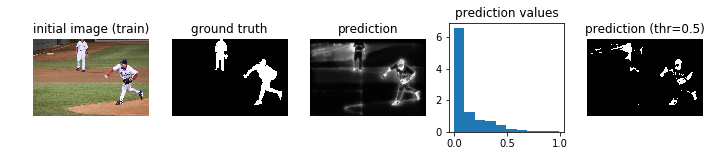

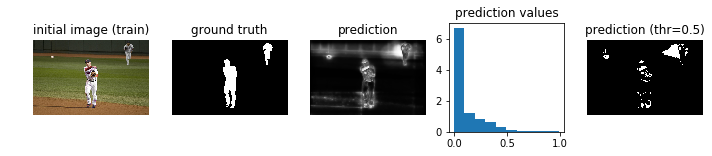

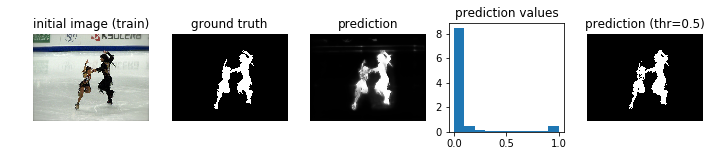

dataset_split: test


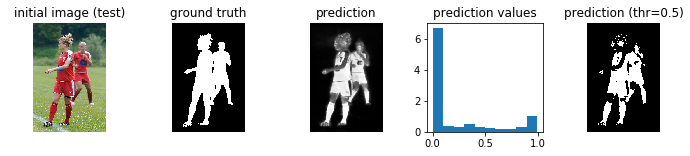

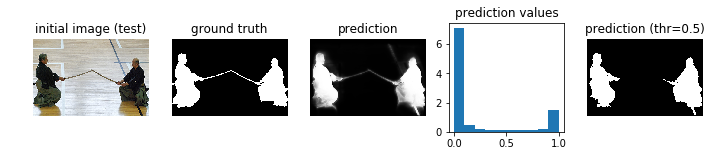

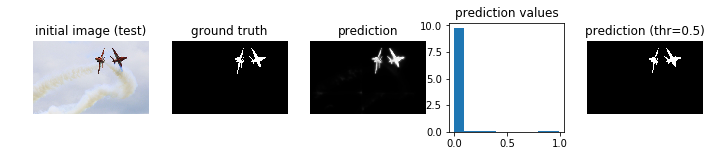

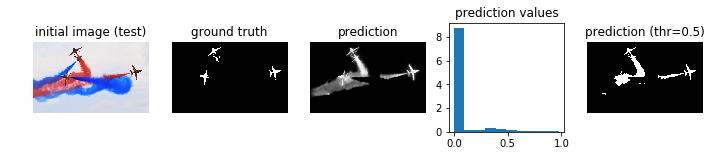

In [14]:
plot_image_mask_prediction(train_images_batch, train_masks_batch, train_preds_batch,
                           dataset_split='train', pred_thr=config.PRED_THR)
plot_image_mask_prediction(test_images_batch, test_masks_batch, test_preds_batch,
                           dataset_split='test', pred_thr=config.PRED_THR)